In [46]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from unidecode import unidecode
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

## 1. Załadowanie danych

In [6]:
df_raw = pd.read_csv(r"data\descriptions\6000-oznaczonych-opisow.csv", header=0)
df_raw

index  Label                                               Opis
0        13      2  Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1        18      2  Wygodne, rozkładowe, częściowo umeblowane mies...
2        43      1  Przedstawiam Państwu ofertę najmu nowego 3-pok...
3        56      1  Wynajmę bezpośrednio piękne, klimatyczne miesz...
4       116      2  Do wynajęcia mieszkanie 70m z tarasem o powier...
...     ...    ...                                                ...
5992   5996      2  Homfi ma przyjemność zaprezentować nowy, komfo...
5993   5997      2  Do wynajęcia apartament położony we Wrocław Kr...
5994   5998      3  UWAGA: WOLNE OD 1 września 2023.OPIS MIESZKANI...
5995   5999      0  Rezerwacja. Do wynajęcia duże wyremontowane 3 ...
5996   6000      0  Wolfies House ma przyjemność zaprezentować dwu...

[5997 rows x 3 columns]

In [7]:
df = df_raw.copy()
df

index  Label                                               Opis
0        13      2  Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1        18      2  Wygodne, rozkładowe, częściowo umeblowane mies...
2        43      1  Przedstawiam Państwu ofertę najmu nowego 3-pok...
3        56      1  Wynajmę bezpośrednio piękne, klimatyczne miesz...
4       116      2  Do wynajęcia mieszkanie 70m z tarasem o powier...
...     ...    ...                                                ...
5992   5996      2  Homfi ma przyjemność zaprezentować nowy, komfo...
5993   5997      2  Do wynajęcia apartament położony we Wrocław Kr...
5994   5998      3  UWAGA: WOLNE OD 1 września 2023.OPIS MIESZKANI...
5995   5999      0  Rezerwacja. Do wynajęcia duże wyremontowane 3 ...
5996   6000      0  Wolfies House ma przyjemność zaprezentować dwu...

[5997 rows x 3 columns]

In [8]:
df["Label"].value_counts()

Label
1    3702
0     937
3     753
2     605
Name: count, dtype: int64

In [9]:
df_nieumeblowane = df[df["Label"] == 0][:605]
df_umeblowane = df[df["Label"] == 1][:605]
df_czesciowo = df[df["Label"] == 2][:605]
df = pd.concat([df_czesciowo, df_umeblowane, df_nieumeblowane], ignore_index=True)
df

index  Label                                               Opis
0        13      2  Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1        18      2  Wygodne, rozkładowe, częściowo umeblowane mies...
2       116      2  Do wynajęcia mieszkanie 70m z tarasem o powier...
3       120      2  Na wynajem - jasne i przytulne mieszkanie dwup...
4       245      2  Aston Nieruchomości ma przyjemność zaprezentow...
...     ...    ...                                                ...
1810   5020      0  ⭐️ Do wynajęcia od zaraz! ⭐️✅OPISPrzedstawiam ...
1811   5022      0  Chojnickie Biuro Nieruchomości oferuje na wyna...
1812   5023      0  Mieszkanie trzy pokoje do wynajęcia. Położone ...
1813   5024      0  1290 ZŁ TO ODSTĘPNE + CZYNSZ 700ZŁ +MEDIA WEDŁ...
1814   5031      0  UMOWA NA WYŁĄCZNOŚĆ . KATOWICE PIOTROWICE UL. ...

[1815 rows x 3 columns]

## 2. Czyszczenie danych
### 2.1 Zapisanie opisów małymi literami

In [10]:
df["Opis"] = df["Opis"].str.lower()
df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul. bruzdowej 100d. mieszkanie gotowe do wynajęcia, dostępne od zaraz, częściowo umeblowane (kuchnia, łazienka i przedpokój). wygodne, przestronne, w sypialni duża szafa, ogródek około 40 m2. sypialnia o powierzchni 15 m2 z dużymi oknami i roletami. do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie -1 w cenie 350 zł. komunikacja autobusowa przy placu vogla i ulicy sytej, tam też znajduje się mini galeria, lidl, biedronka, restauracje, punkty usługowe, miejsca spotkań. osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego, tuż za wałem jest wisła, dużo zieleni, miejsc do spacerów, trasa rowerowa, wiślańskie plaże. podana cena jest bez czynszu administracyjnego, który wynosi 950 zł. wymagany najem okazjonalny. zapraszam zobacz wirtualny spacer: https://panoramy.galactica.pl/virgo/423768pośrednik odpowiedzialny zawodowo za wykonanie umowy pośrednictwa:  (licencja

### 2.2 Usunięcie znaków z alfabetu ukraińskiego

In [11]:
ukrainian_desc = '''
2 wolnostojących domy na działce 1700 m.kw. ul. Beskidzka Rzeszów - 21 pokój mieszkalny, umeblowany, magazyn, Dwa garaży (30 m.kw i 40 m.kw). Idealna nieruchomość dla firmy , usług, mieszkania dla pracowników. Stan bardzo dobry, wyposażony. Dodatkowa informacja - dzwonić jest możliwość wynajmu osobno każdego budynku
2 окремих будинки на ділянці 1700 кв.м. вул. Beskidzka Rzeszów - 21 житлова кімната, мебльована, склад, два гаражі (30 кв. м та 40 кв. м). Ідеальна нерухомість під компанію, послуги, житло для співробітників. Дуже хороший стан, укомплектований. Додаткова інформація - можлива оренда кожної будівлі окремо
'''

def remove_ukrainian_characters(text):
    
    pattern = "[а-яА-ЯіІїЇєЄ]+"
    return re.sub(pattern, "", text)

remove_ukrainian_characters(ukrainian_desc)

'\n2 wolnostojących domy na działce 1700 m.kw. ul. Beskidzka Rzeszów - 21 pokój mieszkalny, umeblowany, magazyn, Dwa garaży (30 m.kw i 40 m.kw). Idealna nieruchomość dla firmy , usług, mieszkania dla pracowników. Stan bardzo dobry, wyposażony. Dodatkowa informacja - dzwonić jest możliwość wynajmu osobno każdego budynku\n2     1700 .. . Beskidzka Rzeszów - 21  , , ,   (30 .   40 . ).    , ,   .   , .   -     \n'

In [12]:
df["Opis"] = df["Opis"].apply(remove_ukrainian_characters)

### 2.3 Usunięcie linków, znaków specjalnych, interpunkcji oraz liczb

In [13]:
from string import digits

def remove_special_chars(text):
    if text is not None:
        text = text.replace('www','https://www')
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
        cleaned_text = re.sub(r"[^\w\s]", "", text)
        cleaned_text = ''.join(filter(lambda x: not x.isdigit(), cleaned_text))
        return cleaned_text
    else:
        return None
    

df["Opis"] = df["Opis"].apply(remove_special_chars)

df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul bruzdowej d mieszkanie gotowe do wynajęcia dostępne od zaraz częściowo umeblowane kuchnia łazienka i przedpokój wygodne przestronne w sypialni duża szafa ogródek około  m sypialnia o powierzchni  m z dużymi oknami i roletami do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie  w cenie  zł komunikacja autobusowa przy placu vogla i ulicy sytej tam też znajduje się mini galeria lidl biedronka restauracje punkty usługowe miejsca spotkań osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego tuż za wałem jest wisła dużo zieleni miejsc do spacerów trasa rowerowa wiślańskie plaże podana cena jest bez czynszu administracyjnego który wynosi  zł wymagany najem okazjonalny zapraszam zobacz wirtualny spacer  odpowiedzialny zawodowo za wykonanie umowy pośrednictwa  licencja nr '

### 2.4 Stemming, lemantyzacja oraz usunięcie stop words
*Stop words* - słowa o małym znaczeniu oraz słowa popularne, czyli niewpływające na identyfikację dokumentu. 

In [14]:
nlp_pl = spacy.load("pl_core_news_md")

opisy_mieszkan = df["Opis"]

przetworzone_opisy = []
for opis in df["Opis"]:
    doc = nlp_pl(opis)
    przetworzony_opis = " ".join([token.lemma_ for token in doc if not token.is_stop])
    przetworzone_opisy.append(przetworzony_opis)

df["Opis"] = przetworzone_opisy
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy d mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### 2.5 Usunięcie pojedyńczych znaków powstałych w trakcie czyszczenia tekstu

In [15]:
def remove_single_letters(text):
    return re.sub(r"\b\w\b\s*", "", text)


# Zastosowanie funkcji do kolumny 'opis_mieszkania'
df["Opis"] = df["Opis"].apply(remove_single_letters)
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### 2.6 Usunięcie polskich znaków 

In [16]:
df["Opis"] = df["Opis"].apply(unidecode)
df["Opis"][0]

'wynajac mieszkanie dwupokojowy ogrodek garaz wilanowa zawada ulica bruzdowy mieszkanie gotowy wynajac dostepny zaraz czesciowo umeblowac kuchnia lazienka przedpokoj wygodny przestronny sypialnia duzy szafa ogrodek   metr sypialnia powierzchnia   metr duzy okno rolet mieszkanie przynalezec miejsce parkingowy duzy komorka lokatorsky poziom   cena   zloty komunikacja autobusowy plac vogla ulica syty znajdowac mini galeria lidl biedronka restauracja punkt uslugowy miejsce spotkanie osiedle zamkniety wyjscie wyjazd wal zawadowskiy tuz wal wisly zielen miejsce spacer trasa rowerowy wislanski plaza podac cena czynsz administracyjny wynosic   zloty wymagac najem okazjonalny zapraszac zobaczyc wirtualny spacer   odpowiedzialny zawodowo wykonac umowa posrednictwo   licencja numer'

## 3. Trenowanie modeli
### 3.1 Podział na dane treningowe i testowe (*20% na zbiór testowy*)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

### 3.2 Wektoryzacja danych tekstowych z wykorzystaniem Bi-Gramów (1000 najczęsciej występujących tokenów)

In [59]:
bigram = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_train = bigram.fit_transform(X_train)
X_test = bigram.transform(X_test)


In [60]:
df_bigram_vec = pd.DataFrame(data=X_train.toarray(), 
                  columns=bigram.get_feature_names_out())

df_bigram_vec

access  access the  additional  administracja  administracyjny  \
0          1           0           1              0                0   
1          0           0           0              0                2   
2          0           0           0              0                0   
3          0           0           0              0                0   
4          0           0           0              0                1   
...      ...         ...         ...            ...              ...   
1447       0           0           0              0                1   
1448       0           0           0              0                1   
1449       0           0           0              0                1   
1450       0           0           0              0                0   
1451       1           0           0              0                1   

      administracyjny zloty  administrative  administrator  adres  agd  ...  \
0                         0               0              0      0    1  ...   
1                         1               0              0      0    1  ...   
2                         0               0              0      0    0  ...   
3                         0               0              0      0    0  ...   
4                         0               0              0      0    1  ...   
...                     ...             ...            ...    ...  ...  ...   
1447                      1               0              0      0    0  ...   
1448                      0               0              0      0    0  ...   
1449                      0               0              0      0    0  ...   
1450                      0               0              0      0    0  ...   
1451                      0               1              0      0    0  ...   

      zmywarka piekarnik  znajdowac  znajdowac pietro  znalezc  zostac  \
0                      0          3                 0        0       0   
1                      0          0                 0        0       0   
2                      0          1                 0        0       0   
3                      0          1                 1        0       0   
4                      0          2                 0        0       0   
...                  ...        ...               ...      ...     ...   
1447                   0          1                 0        0       0   
1448                   0          0                 0        0       0   
1449                   0          2                 0        0       0   
1450                   0          1                 1        0       0   
1451                   0          0                 0        0       0   

      zuzycie  zwierze  zwrotny  zwrotny zloty  zycie  
0           1        0        0              0      0  
1           1        0        1              1      0  
2           1        0        1              1      0  
3           0        0        0              0      0  
4           0        0        1              0      0  
...       ...      ...      ...            ...    ...  
1447        0        0        0              0      0  
1448        0        0        0              0      0  
1449        0        0        0              0      0  
1450        0        0        1              0      0  
1451        1        0        1              0      0  

[1452 rows x 1000 columns]

### 3.3 Drzewo decyzyjne
#### 3.3.1 Trening modelu

In [65]:
dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 1.0
Dokładność na zbiorze testowym: 0.7520661157024794

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       122
           1       0.84      0.86      0.85       110
           2       0.70      0.70      0.70       131

    accuracy                           0.75       363
   macro avg       0.76      0.76      0.76       363
weighted avg       0.75      0.75      0.75       363



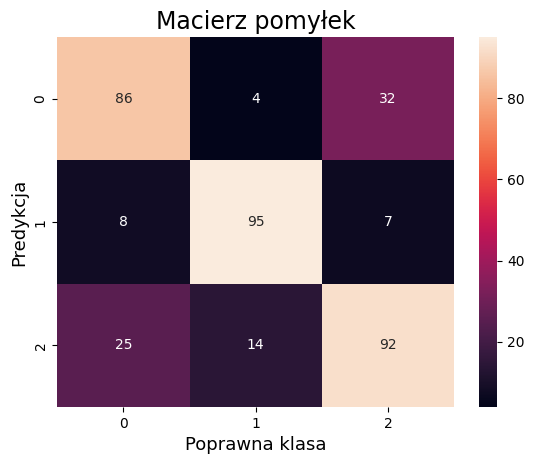

In [66]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna klasa", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

In [69]:
plt.figure(figsize=(20, 10), dpi=1000)
plot_tree(dt_clf, feature_names=bigram.get_feature_names_out().tolist(), class_names=["0", "1", "2"], filled=True, rounded=True)
plt.show()

#### 3.3.2 Dostrojenie modelu z wykorzystaniem przeszukiwania siatki hiperparametrów (*3-krotna walidacja krzyżowa*)

In [70]:
param_grid = {'criterion':['gini','entropy'], 'max_depth':[3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_model = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 38 candidates, totalling 114 fits
[CV 1/3] END .......criterion=gini, max_depth=3;, score=0.758 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=3;, score=0.787 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=3;, score=0.771 total time=   0.0s
[CV 1/3] END .......criterion=gini, max_depth=4;, score=0.758 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=4;, score=0.785 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=4;, score=0.781 total time=   0.0s
[CV 1/3] END .......criterion=gini, max_depth=5;, score=0.736 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=5;, score=0.775 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=5;, score=0.781 total time=   0.0s
[CV 1/3] END .......criterion=gini, max_depth=6;, score=0.769 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=6;, score=0.783 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=6

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20,
                                       30, 40, 50, 70, 90, 120, 150]},
             verbose=3)

In [71]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'criterion': 'entropy', 'max_depth': 4}
DecisionTreeClassifier(criterion='entropy', max_depth=4)


In [72]:
y_pred = grid_model.predict(X_test)
accuracy_train = grid_model.score(X_train, y_train)
print(f'Dokładność na zbiorze treningowym: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(X_test, y_test)
print(f'Dokładność na zbiorze testowym: {round(accuracy_test * 100, 2)}%')
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 79.27%
Dokładność na zbiorze testowym: 79.89%
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       122
           1       0.79      0.94      0.85       110
           2       0.77      0.76      0.76       131

    accuracy                           0.80       363
   macro avg       0.80      0.80      0.80       363
weighted avg       0.80      0.80      0.80       363



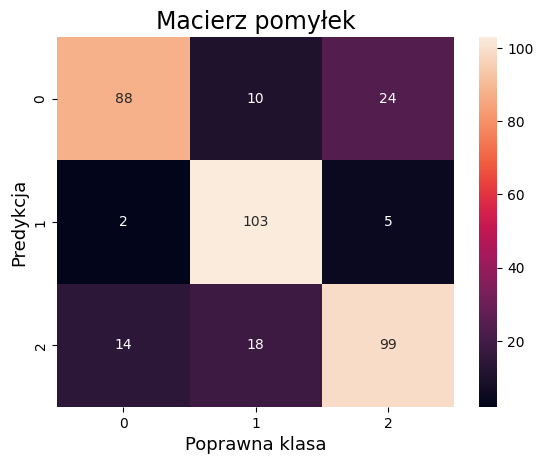

In [73]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna klasa", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

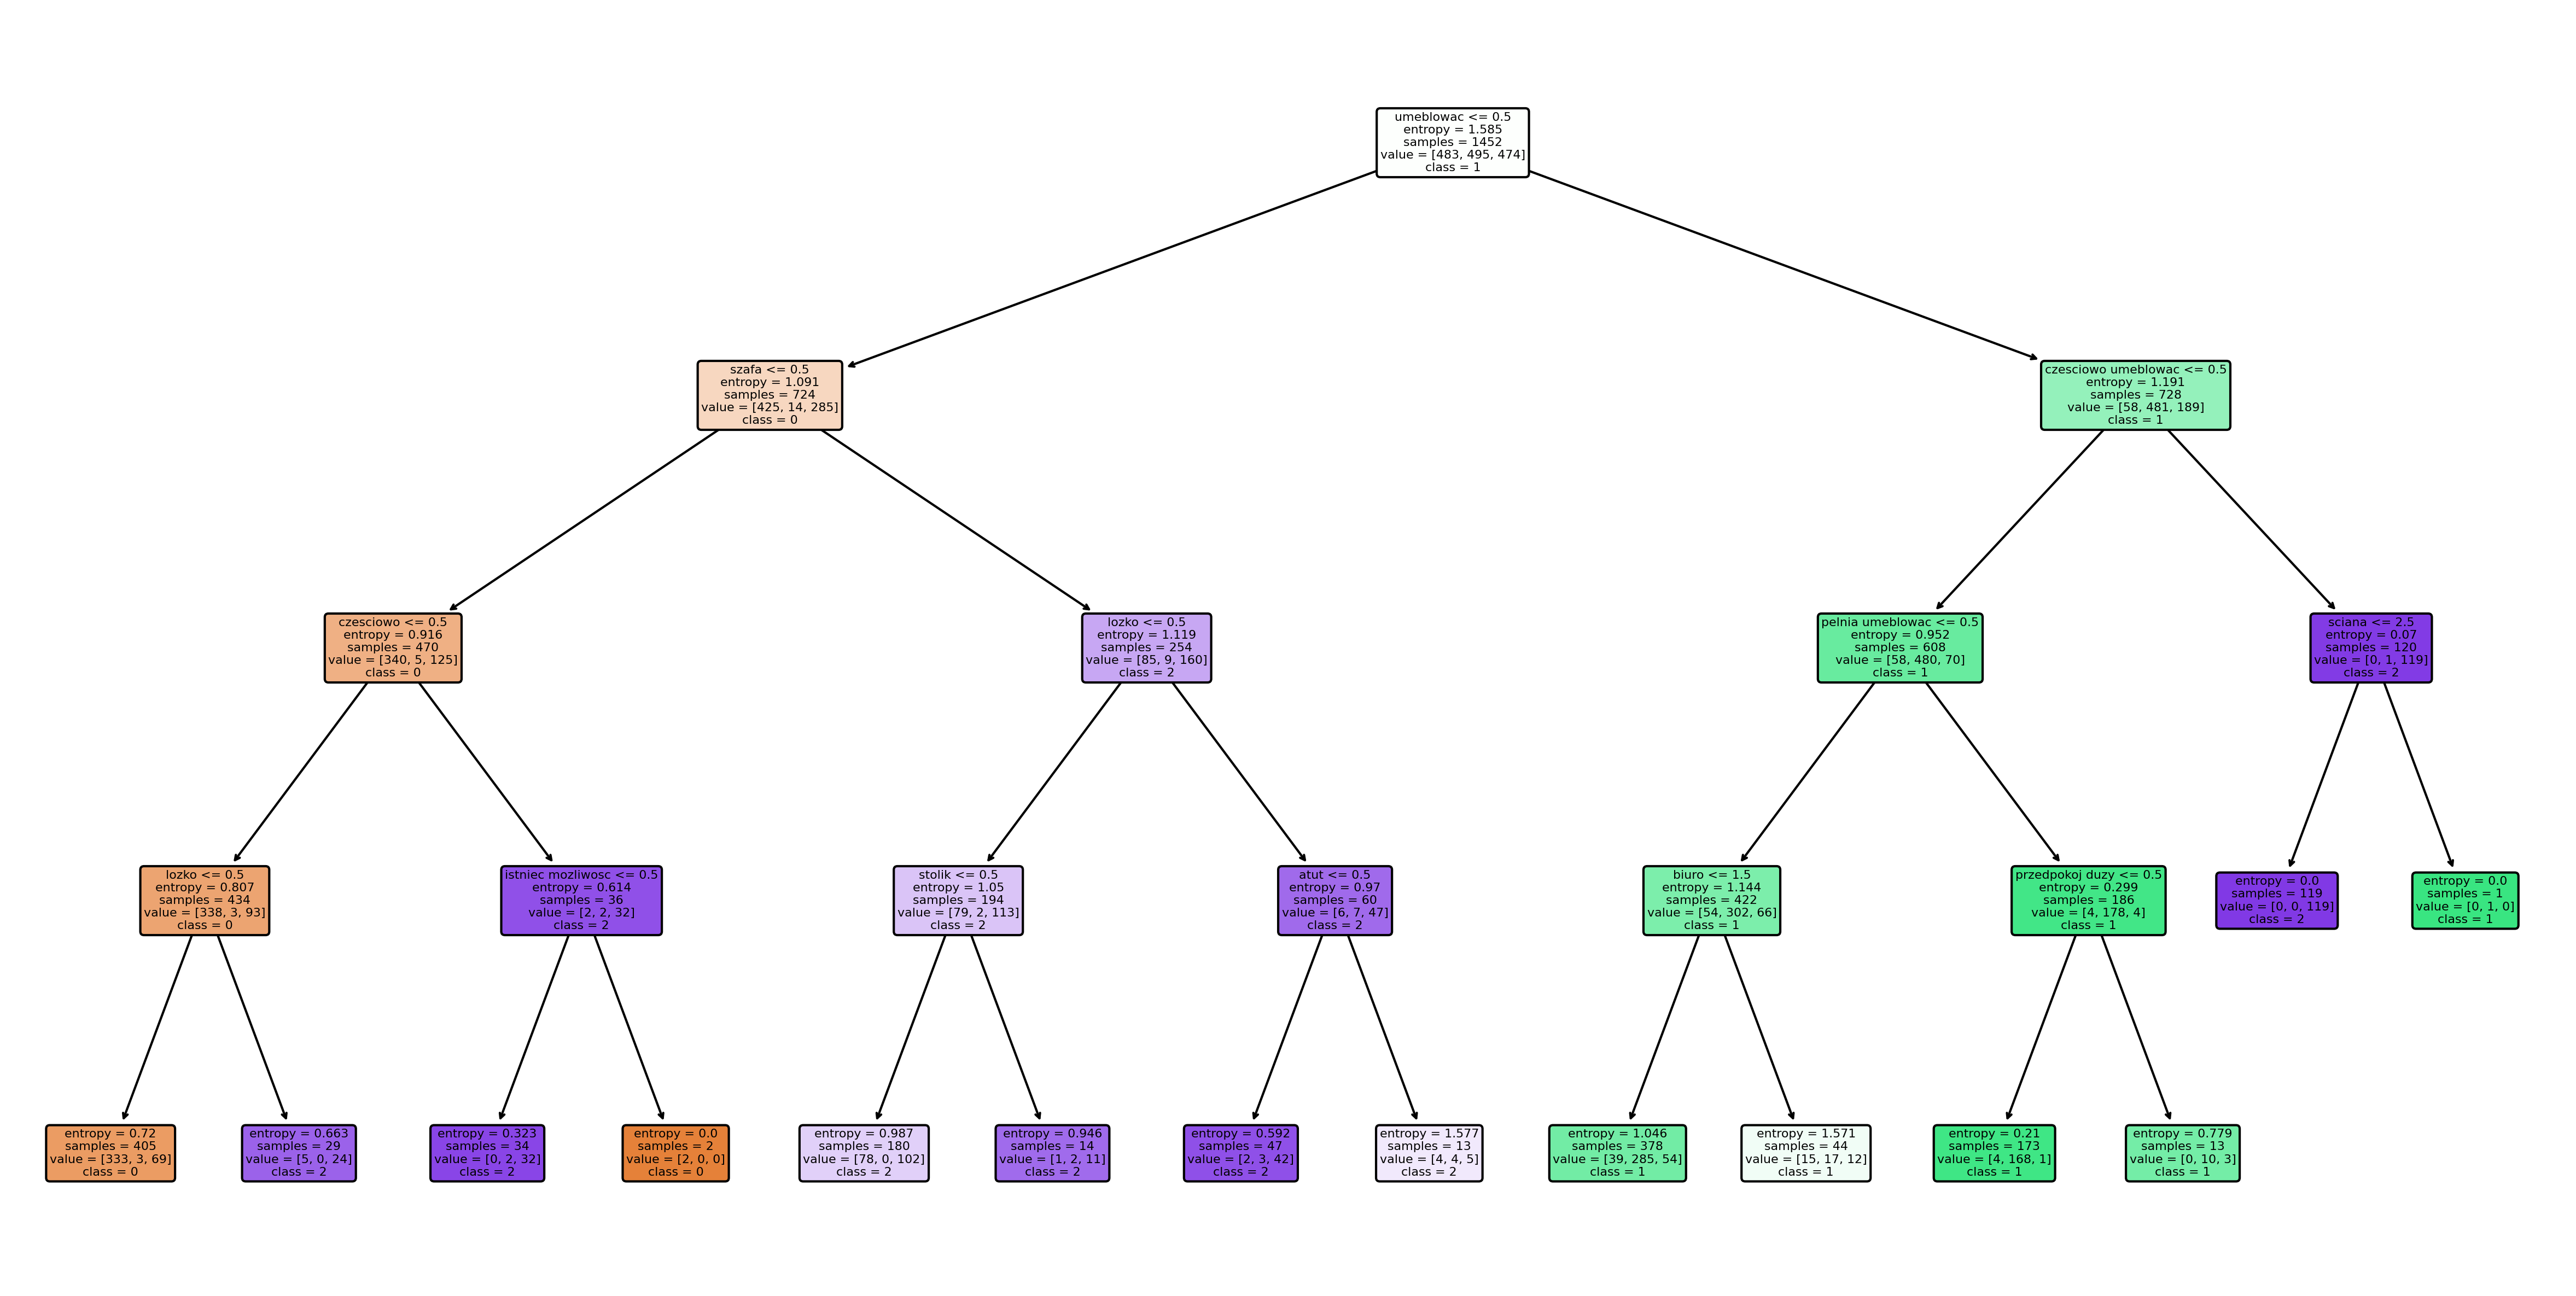

In [74]:
plt.figure(figsize=(20, 10), dpi=300)
plot_tree(grid_model.best_estimator_, feature_names=bigram.get_feature_names_out().tolist(), class_names=["0", "1", "2"], filled=True, rounded=True)
plt.show()

### 3.4 Maszyna wektorów nośnych

In [76]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8705234159779615
Dokładność na zbiorze testowym: 0.6584022038567493

              precision    recall  f1-score   support

           0       0.61      0.79      0.69       122
           1       0.72      0.79      0.75       110
           2       0.67      0.43      0.52       131

    accuracy                           0.66       363
   macro avg       0.66      0.67      0.65       363
weighted avg       0.66      0.66      0.65       363



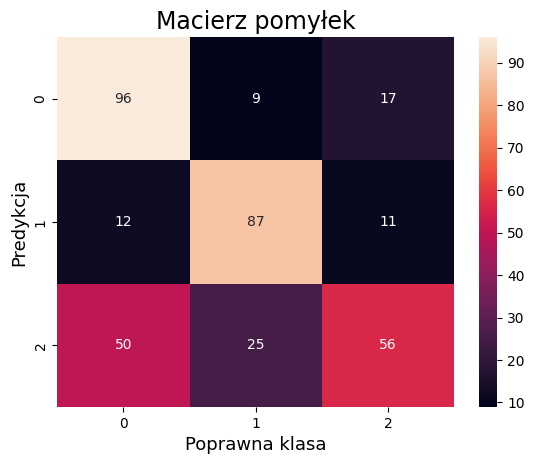

In [77]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna klasa", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

#### 3.4.1 Dostrojenie modelu z wykorzystaniem przeszukiwania siatki hiperparametrów (*3-krotna walidacja krzyżowa*)

In [78]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'linear']}

grid_model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END .......C=0.01, gamma=1, kernel=rbf;, score=0.341 total time=   1.1s
[CV 2/3] END .......C=0.01, gamma=1, kernel=rbf;, score=0.341 total time=   1.1s
[CV 3/3] END .......C=0.01, gamma=1, kernel=rbf;, score=0.341 total time=   1.1s
[CV 1/3] END ......C=0.01, gamma=1, kernel=poly;, score=0.610 total time=   1.0s
[CV 2/3] END ......C=0.01, gamma=1, kernel=poly;, score=0.583 total time=   1.0s
[CV 3/3] END ......C=0.01, gamma=1, kernel=poly;, score=0.601 total time=   1.0s
[CV 1/3] END ....C=0.01, gamma=1, kernel=linear;, score=0.715 total time=   0.9s
[CV 2/3] END ....C=0.01, gamma=1, kernel=linear;, score=0.719 total time=   0.8s
[CV 3/3] END ....C=0.01, gamma=1, kernel=linear;, score=0.717 total time=   0.8s
[CV 1/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.341 total time=   1.2s
[CV 2/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.341 total time=   1.2s
[CV 3/3] END .....C=0.01, gamma=0.1, kernel=rb

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 50, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'linear']},
             verbose=3)

In [79]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [80]:
y_pred = grid_model.predict(X_test)
accuracy_train = grid_model.score(X_train, y_train)
print(f'Dokładność na zbiorze treningowym: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(X_test, y_test)
print(f'Dokładność na zbiorze testowym: {round(accuracy_test * 100, 2)}%')
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 94.77%
Dokładność na zbiorze testowym: 71.07%
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       122
           1       0.77      0.83      0.80       110
           2       0.69      0.56      0.62       131

    accuracy                           0.71       363
   macro avg       0.71      0.72      0.71       363
weighted avg       0.71      0.71      0.71       363



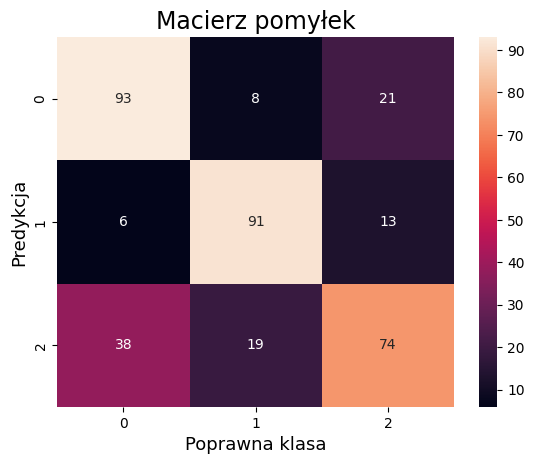

In [81]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna klasa", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### 3.5 Regresja logistyczna
#### 3.5.1 Trening modelu

In [82]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {logreg_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {logreg_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.9965564738292011
Dokładność na zbiorze testowym: 0.7079889807162535

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       122
           1       0.83      0.77      0.80       110
           2       0.68      0.62      0.65       131

    accuracy                           0.71       363
   macro avg       0.72      0.71      0.71       363
weighted avg       0.71      0.71      0.71       363



c:\Users\wilko\Desktop\Studia\Projekty swoje\Python\Machine learning\NLP-text-classification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


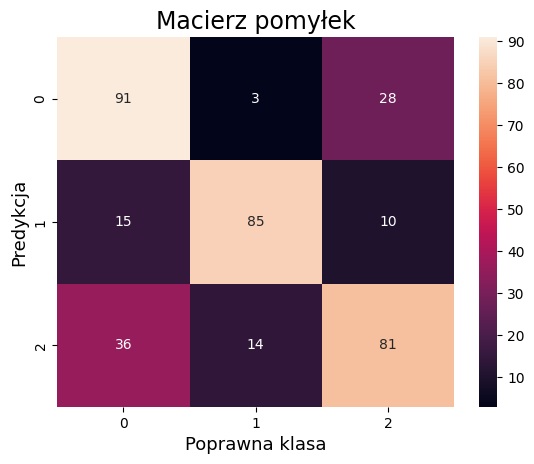

In [83]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna klasa", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

#### 3.5.2 Dostrojenie modelu z wykorzystaniem przeszukiwania siatki hiperparametrów (*3-krotna walidacja krzyżowa*)

In [ ]:
param_grid = param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
}

grid_model = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(X_train, y_train)

In [85]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'C': 0.03359818286283781, 'penalty': 'l2'}
LogisticRegression(C=0.03359818286283781)


In [86]:
y_pred = grid_model.predict(X_test)
accuracy_train = grid_model.score(X_train, y_train)
print(f'Dokładność na zbiorze treningowym: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(X_test, y_test)
print(f'Dokładność na zbiorze testowym: {round(accuracy_test * 100, 2)}%')
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 92.63%
Dokładność na zbiorze testowym: 73.83%
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       122
           1       0.82      0.83      0.82       110
           2       0.73      0.60      0.66       131

    accuracy                           0.74       363
   macro avg       0.74      0.74      0.74       363
weighted avg       0.74      0.74      0.74       363



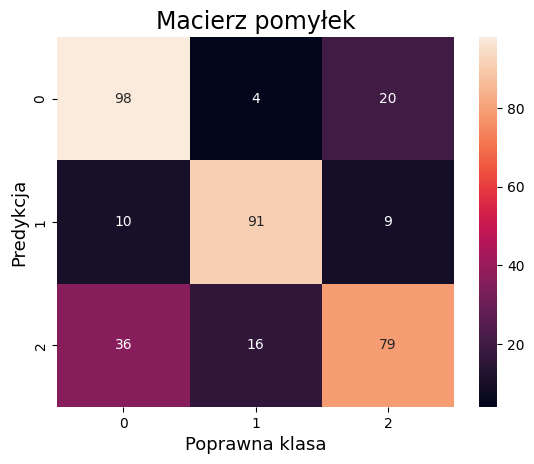

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna klasa", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### 3.6 Wektoryzacja danych tekstowych z wykorzystaniem macierzy TF-IDF
TfidfVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu opisowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w macierzy TF-IDF są obliczane dla każdego słowa w każdym opisie. Wagi odzwierciedlają istotność danego słowa w konkretnym opisie w kontekście całego zbioru opisów.


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

tfidf = TfidfVectorizer(max_features=1000) 
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [92]:
df_tfidf = pd.DataFrame(data=X_train.toarray(), 
                  columns=tfidf.get_feature_names_out())

df_tfidf

about  above    access  according  additional  administracja  \
0     0.038628    0.0  0.032112   0.037760    0.037278            0.0   
1     0.000000    0.0  0.000000   0.000000    0.000000            0.0   
2     0.000000    0.0  0.000000   0.000000    0.000000            0.0   
3     0.000000    0.0  0.000000   0.000000    0.000000            0.0   
4     0.000000    0.0  0.000000   0.000000    0.000000            0.0   
...        ...    ...       ...        ...         ...            ...   
1447  0.000000    0.0  0.000000   0.000000    0.000000            0.0   
1448  0.000000    0.0  0.000000   0.100340    0.000000            0.0   
1449  0.000000    0.0  0.000000   0.000000    0.000000            0.0   
1450  0.000000    0.0  0.000000   0.000000    0.000000            0.0   
1451  0.000000    0.0  0.047270   0.055584    0.000000            0.0   

      administracyjny  administrative  administrator  adres  ...  zmywarka  \
0            0.000000        0.000000            0.0    0.0  ...  0.000000   
1            0.079528        0.000000            0.0    0.0  ...  0.047769   
2            0.000000        0.000000            0.0    0.0  ...  0.000000   
3            0.000000        0.000000            0.0    0.0  ...  0.000000   
4            0.047847        0.000000            0.0    0.0  ...  0.057480   
...               ...             ...            ...    ...  ...       ...   
1447         0.070529        0.000000            0.0    0.0  ...  0.000000   
1448         0.044173        0.000000            0.0    0.0  ...  0.053066   
1449         0.083692        0.000000            0.0    0.0  ...  0.100541   
1450         0.000000        0.000000            0.0    0.0  ...  0.000000   
1451         0.024470        0.049194            0.0    0.0  ...  0.000000   

      znajdowac  znajduc  znalezc  zostac   zuzycie  zwiazac  zwierze  \
0      0.045242      0.0      0.0     0.0  0.021353      0.0      0.0   
1      0.000000      0.0      0.0     0.0  0.051077      0.0      0.0   
2      0.059506      0.0      0.0     0.0  0.084254      0.0      0.0   
3      0.074861      0.0      0.0     0.0  0.000000      0.0      0.0   
4      0.086814      0.0      0.0     0.0  0.000000      0.0      0.0   
...         ...      ...      ...     ...       ...      ...      ...   
1447   0.063985      0.0      0.0     0.0  0.000000      0.0      0.0   
1448   0.000000      0.0      0.0     0.0  0.000000      0.0      0.0   
1449   0.151852      0.0      0.0     0.0  0.000000      0.0      0.0   
1450   0.069911      0.0      0.0     0.0  0.000000      0.0      0.0   
1451   0.000000      0.0      0.0     0.0  0.031432      0.0      0.0   

       zwrotny  zycie  
0     0.000000    0.0  
1     0.061181    0.0  
2     0.100921    0.0  
3     0.000000    0.0  
4     0.073618    0.0  
...        ...    ...  
1447  0.000000    0.0  
1448  0.000000    0.0  
1449  0.000000    0.0  
1450  0.118568    0.0  
1451  0.037649    0.0  

[1452 rows x 1000 columns]

### 3.7 Drzewo decyzyjne
#### 3.7.1 Trening modelu

In [93]:
dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 1.0
Dokładność na zbiorze testowym: 0.721763085399449

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       122
           1       0.79      0.78      0.79       110
           2       0.66      0.70      0.68       131

    accuracy                           0.72       363
   macro avg       0.73      0.72      0.73       363
weighted avg       0.72      0.72      0.72       363



#### 3.7.2 Dostrojenie modelu z wykorzystaniem przeszukiwania siatki hiperparametrów (*3-krotna walidacja krzyżowa*)

In [94]:
param_grid = {'criterion':['gini','entropy'], 'max_depth':[3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_model = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 38 candidates, totalling 114 fits
[CV 1/3] END .......criterion=gini, max_depth=3;, score=0.767 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=3;, score=0.795 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=3;, score=0.767 total time=   0.0s
[CV 1/3] END .......criterion=gini, max_depth=4;, score=0.777 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=4;, score=0.793 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=4;, score=0.785 total time=   0.0s
[CV 1/3] END .......criterion=gini, max_depth=5;, score=0.767 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=5;, score=0.798 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=5;, score=0.742 total time=   0.0s
[CV 1/3] END .......criterion=gini, max_depth=6;, score=0.764 total time=   0.0s
[CV 2/3] END .......criterion=gini, max_depth=6;, score=0.762 total time=   0.0s
[CV 3/3] END .......criterion=gini, max_depth=6

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20,
                                       30, 40, 50, 70, 90, 120, 150]},
             verbose=3)

In [95]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'criterion': 'gini', 'max_depth': 4}
DecisionTreeClassifier(max_depth=4)


In [96]:
y_pred = grid_model.predict(X_test)
accuracy_train = grid_model.score(X_train, y_train)
print(f'Dokładność na zbiorze treningowym: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(X_test, y_test)
print(f'Dokładność na zbiorze testowym: {round(accuracy_test * 100, 2)}%')
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 82.02%
Dokładność na zbiorze testowym: 78.79%
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       122
           1       0.81      0.93      0.86       110
           2       0.78      0.67      0.72       131

    accuracy                           0.79       363
   macro avg       0.79      0.80      0.79       363
weighted avg       0.79      0.79      0.78       363



### 3.8 Maszyna wektorów nośnych
#### 3.8.1 Trening modelu

In [97]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.9696969696969697
Dokładność na zbiorze testowym: 0.6611570247933884

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       122
           1       0.68      0.76      0.72       110
           2       0.67      0.51      0.58       131

    accuracy                           0.66       363
   macro avg       0.66      0.67      0.66       363
weighted avg       0.66      0.66      0.66       363



#### 3.8.2 Dostrojenie modelu z wykorzystaniem przeszukiwania siatki hiperparametrów (*3-krotna walidacja krzyżowa*)

In [98]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'linear']}

grid_model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END .......C=0.01, gamma=1, kernel=rbf;, score=0.341 total time=   1.0s
[CV 2/3] END .......C=0.01, gamma=1, kernel=rbf;, score=0.341 total time=   1.0s
[CV 3/3] END .......C=0.01, gamma=1, kernel=rbf;, score=0.341 total time=   1.0s
[CV 1/3] END ......C=0.01, gamma=1, kernel=poly;, score=0.341 total time=   1.0s
[CV 2/3] END ......C=0.01, gamma=1, kernel=poly;, score=0.341 total time=   0.9s
[CV 3/3] END ......C=0.01, gamma=1, kernel=poly;, score=0.341 total time=   0.9s
[CV 1/3] END ....C=0.01, gamma=1, kernel=linear;, score=0.341 total time=   0.9s
[CV 2/3] END ....C=0.01, gamma=1, kernel=linear;, score=0.341 total time=   0.9s
[CV 3/3] END ....C=0.01, gamma=1, kernel=linear;, score=0.341 total time=   0.9s
[CV 1/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.341 total time=   1.0s
[CV 2/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.341 total time=   0.9s
[CV 3/3] END .....C=0.01, gamma=0.1, kernel=rb

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 50, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'linear']},
             verbose=3)

In [99]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [100]:
y_pred = grid_model.predict(X_test)
accuracy_train = grid_model.score(X_train, y_train)
print(f'Dokładność na zbiorze treningowym: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(X_test, y_test)
print(f'Dokładność na zbiorze testowym: {round(accuracy_test * 100, 2)}%')
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 99.45%
Dokładność na zbiorze testowym: 70.52%
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       122
           1       0.76      0.77      0.77       110
           2       0.67      0.61      0.64       131

    accuracy                           0.71       363
   macro avg       0.71      0.71      0.71       363
weighted avg       0.70      0.71      0.70       363



### 3.9 Regresja logistyczna
#### 3.9.1 Trening modelu

In [101]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {logreg_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {logreg_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.8705234159779615
Dokładność na zbiorze testowym: 0.6721763085399449

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       122
           1       0.67      0.79      0.72       110
           2       0.70      0.53      0.60       131

    accuracy                           0.67       363
   macro avg       0.68      0.68      0.67       363
weighted avg       0.68      0.67      0.67       363



#### 3.9.2 Dostrojenie modelu z wykorzystaniem przeszukiwania siatki hiperparametrów (*3-krotna walidacja krzyżowa*)

In [ ]:
param_grid = param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
}

grid_model = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(X_train, y_train)

In [103]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'C': 4.281332398719396, 'penalty': 'l2'}
LogisticRegression(C=4.281332398719396)


In [104]:
y_pred = grid_model.predict(X_test)
accuracy_train = grid_model.score(X_train, y_train)
print(f'Dokładność na zbiorze treningowym: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(X_test, y_test)
print(f'Dokładność na zbiorze testowym: {round(accuracy_test * 100, 2)}%')
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 93.8%
Dokładność na zbiorze testowym: 70.25%
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       122
           1       0.76      0.82      0.79       110
           2       0.68      0.59      0.63       131

    accuracy                           0.70       363
   macro avg       0.70      0.71      0.70       363
weighted avg       0.70      0.70      0.70       363

